In [ ]:
import pandas as pd
from datetime import datetime
import copy
from pyxirr import xirr
from IPython import display
import sys

In [ ]:
sys.path.append("F:/my-quant") 
from commons import Portfolio, ProgressBoard, Regression, HyperParameters, AkShareData, Strategy

In [64]:
class BollData(AkShareData):

    def load_boll_data(self):
        boll = super().load_boll_data()
        boll['MAVOL'] = boll['vol'].rolling(window=30).mean().round(3)
        return boll
        

class BollMid(Strategy):
    def __init__(self, data_loader, max_loss=(0, 0.02), interval=0, max_pos=10, daily_budge=2000):
        super().__init__(max_pos, daily_budge)
        self.save_hyperparameters()
        self.boll_data = data_loader.load_boll_data()
        
    def _eval(self, curr_time, price_row):
        boll_data = self.boll_data
        boll_row = boll_data[boll_data['date'] < curr_time.strftime('%Y-%m-%d')].tail(1)
        if len(boll_row) == 0:
            return
        
        boll = boll_row['MID'].item()
        if boll != boll:
            # boll is nan
            return

        mavol = boll_row['MAVOL'].item()
        
        min_loss, max_loss = self.max_loss
        portfolio = self.portfolio
        
        bp = round(boll / (1 - max_loss), 3)
        bp_low = round(boll / (1 - min_loss), 3)
        sl = boll
        
        op, cp, hp, lp, vol, money = price_row.values
        trade = { 'date': curr_time, 'sl': sl, 'bp': bp, 'op': op, 'cp': cp, 'hp': hp, 'lp': lp, 'vol': vol }

        prev_buy_days = (curr_time - self.portfolio.last_buy).days
        buy, price = self.buy_signal(sl, bp_low, bp, op, cp, hp, lp, vol, prev_buy_days)
        if buy:
            self.buy(lambda: trade, price)
            portfolio.last_buy = curr_time
        
        sell, price = self.sell_signal(sl, bp_low, bp, op, cp, hp, lp, vol, mavol)
        if sell:
            # 触发止损
            self.sell(lambda: trade, price)
            portfolio.last_sell = curr_time
                
        wait, price = self.wait_signal(sl, bp_low, bp, op, cp, hp, lp, vol)
        if wait:
            self.wait(price)
        
        portfolio.net_worth_his.append({
            'date': curr_time,
            'net_worth': portfolio.net_worth
        })
        
    def _eval_last(self, curr_time, price_row):
        op, cp, hp, lp, vol, money = price_row.values
        trade = { 'date': curr_time, 'sl': None, 'bp': None, 'op': op, 'cp': cp, 'hp': hp, 'lp': lp, 'vol': vol }
        self.dummy_sell(lambda: trade, cp)

    def buy_signal(self, sl, bp_low, bp, op, cp, hp, lp, vol, prev_buy_days):
        interval = self.interval
        max_pos = self.max_pos
        price = cp
        
        price_ok = sl < price and price <= bp and bp_low < price
        interval_ok = prev_buy_days >= interval
        position_ok = len(self.portfolio.position) < max_pos

        return price_ok and interval_ok and position_ok, price

    def sell_signal(self, sl, bp_low, bp, op, cp, hp, lp, vol, mavol):
        price = cp
        position = self.portfolio.position

        avg_price = sum(x.get('pos', 0) * x.get('price', 0) for x in position) / (sum(x.get('pos', 0) for x in position) + 0.000001)

        price_ok = price <= sl

        avg_price_loss = (price - avg_price) / avg_price < self.max_loss[1]
        
        return price_ok and (avg_price_loss or vol > mavol), price

    def wait_signal(self, sl, bp_low, bp, op, cp, hp, lp, vol):
        price = cp
        return bp < price, price

    

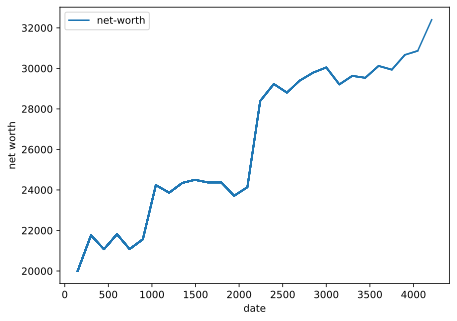

In [65]:
lr_list       = [(0, 0.02)] #[(0,0.01), (0, 0.02), (0, 0.05), (0, 0.1)]
interval_list = [0] #[0, 3, 5, 10]
max_pos_list  = [10] # [1, 2, 5, 10]

report_list = []
trade_list= []
portfolio_list = []
for i in range(3, 4):
    nk = (30, 2)
    boll_args = ('518880', '20130729', '20250501', 'daily', *nk)
    his_args  = ('518880', '20130729', '20250501', 'daily')
    data = BollData(boll_args, his_args)
    for lr in lr_list:
        for interval in interval_list:
            for max_pos in max_pos_list:
                regression = Regression()
                strategy=BollMid(data, max_loss=lr, interval=interval, max_pos=max_pos, daily_budge = 2000)
                regression.reg_test(strategy, data, every_n=100)
                portfolio = strategy.portfolio
                portfolio_list.append(copy.deepcopy(portfolio))
                # ovw, t = save(copy.deepcopy(portfolio), start_time, end_time, nk)
                # report_list.append(ovw)
                # trade_list.append(t)

In [66]:
trades = pd.json_normalize(portfolio_list[0].trades)
trades['profit'] = trades['sell.money'] - trades['buy.money']

trades.to_csv('data/trades.csv')
print(trades['profit'].sum())

net_worth = pd.json_normalize(portfolio_list[0].net_worth_his)
net_worth.to_csv('data/net_worth.csv')

pos = len(trades[trades['profit'] > 0])
neg = len(trades[trades['profit'] <= 0])

print(f'{neg} / {pos} = {(neg / pos):.2f}') 

trades.insert(1, 'profit', trades.pop('profit'))
trades.insert(1, 'sell.date', trades.pop('sell.date'))

trades[trades['profit'] <= 0][:10]


15473.199999999997
402 / 219 = 1.84


,buy.date,sell.date,profit,buy.sl,buy.bp,buy.op,buy.cp,buy.hp,buy.lp,buy.vol,...,sell.sl,sell.bp,sell.op,sell.cp,sell.hp,sell.lp,sell.vol,sell.pos,sell.money,sell.price
0,2013-09-10,2013-09-12,-42.0,2.700,2.755,buy,2.742,2.756,2.737,92940.0,...,2.706,2.761,sell,2.682,2.714,2.676,48856.0,700.0,1877.4,2.682
1,2013-09-11,2013-09-12,-28.0,2.703,2.758,buy,2.722,2.722,2.700,59378.0,...,2.706,2.761,sell,2.682,2.714,2.676,48856.0,700.0,1877.4,2.682
2,2013-10-29,2013-10-31,-18.2,2.624,2.678,buy,2.639,2.645,2.630,50240.0,...,2.617,2.670,sell,2.613,2.620,2.607,19669.0,700.0,1829.1,2.613
3,2013-10-30,2013-10-31,-12.6,2.621,2.674,buy,2.631,2.634,2.612,45218.0,...,2.617,2.670,sell,2.613,2.620,2.607,19669.0,700.0,1829.1,2.613
4,2014-01-03,2014-01-08,-10.4,2.417,2.466,buy,2.424,2.425,2.411,38247.0,...,2.415,2.464,sell,2.411,2.422,2.410,20957.0,800.0,1928.8,2.411
5,2014-01-06,2014-01-08,-19.2,2.416,2.465,buy,2.435,2.445,2.410,48167.0,...,2.415,2.464,sell,2.411,2.422,2.410,20957.0,800.0,1928.8,2.411
6,2014-01-07,2014-01-08,-24.8,2.415,2.464,buy,2.442,2.445,2.430,51299.0,...,2.415,2.464,sell,2.411,2.422,2.410,20957.0,800.0,1928.8,2.411
17,2014-04-14,2014-04-15,-27.3,2.627,2.681,buy,2.649,2.649,2.629,25169.0,...,2.628,2.682,sell,2.610,2.646,2.410,28738.0,700.0,1827.0,2.610
18,2014-04-28,2014-04-29,-19.6,2.609,2.662,buy,2.631,2.635,2.613,23277.0,...,2.607,2.660,sell,2.603,2.628,2.599,27691.0,700.0,1822.1,2.603
19,2014-04-30,2014-05-08,-17.5,2.603,2.656,buy,2.612,2.615,2.602,17222.0,...,2.597,2.650,sell,2.587,2.596,2.582,12130.0,700.0,1810.9,2.587


In [13]:
df = pd.json_normalize(portfolio_list[0].net_worth_his)

def max_drawdown(df):
    df['peak'] = df['net_worth'].cummax()
    df['drawdown'] = (df['net_worth'] - df['peak']) / df['peak']
    
    end_idx = df['drawdown'].idxmin()
    start_idx = df.loc[:end_idx, 'net_worth'].idxmax()
    
    max_drawdown = df.loc[end_idx, 'drawdown']  # 最大回撤率
    start_date = df.loc[start_idx, 'date']
    end_date = df.loc[end_idx, 'date']
    
    print(f"最大回撤区间：{start_date} 到 {end_date}，回撤率：{max_drawdown:.2%}")

def yield_rate(df, start_time, end_time):
    start = df[df['date'] >= start_time].head(1)
    end = df[df['date'] <= end_time].tail(1)
    nw_start = start['net_worth'].item()
    nw_end = end['net_worth'].item()
    print(f"{start['date'].item()} ~ {end['date'].item()}: {(nw_end - nw_start) * 100 / nw_start:.2f}")

In [30]:
boll_args = ('518880', '20130729', '20250501', 'daily', *nk)
his_args  = ('518880', '20130729', '20250501', 'daily')
data = BollData(boll_args, his_args)

dd = data.load_boll_data()
dd[dd['date'] == '2014-01-08']

,date,open,close,high,low,vol,money,振幅,涨跌幅,涨跌额,换手率,std,MID,UP,LOW,vol30
109,2014-01-08,2.415,2.411,2.422,2.41,20957,5062486.0,0.49,-1.27,-0.031,0.03,0.031,2.414,2.476,2.352,54305.133


In [ ]:
dd['ma60'] = dd['close'].rolling(window=60).mean().round(3)
dd['ma30>ma60'] = dd['MID'] > dd['ma60']

dd['previous'] = dd['ma30>ma60'].shift(1)
dd['golden_cross'] = (dd['ma30>ma60'] == True) & (dd['previous'] == False)
dd['death_cross'] = (dd['ma30>ma60'] == False) & (dd['previous'] == True)

golden_dates = dd.loc[dd['golden_cross'], 'date'].tolist()
death_dates = dd.loc[dd['death_cross'], 'date'].tolist()

for (g, d) in zip(golden_dates, death_dates):
    yield_rate(df, g, d)

print()

date_points = sorted(golden_dates + death_dates)
date_points.append('2025-05-01')

date_start = None
date_end = None
for x in date_points:
    date_start = date_end
    date_end = x
    if date_start:
        yield_rate(df, date_start, date_end)
